In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geopy.distance as geo
from docplex.mp.model import Model

In [46]:
##### Loading school data

school_df = pd.read_csv("Schools_Coordinates.csv")
display(school_df.head())

,Unnamed: 0,School Name,Village,Coordinates,Demand
0,0,Kitchen Akshay Patra,Baroda City,"22.315718, 73.153501",x
1,1,Government School Baroda,Akota Village,"22.297335, 73.177502",234
2,2,Government School Baroda,NagarWada,"22.306992, 73.201968",249
3,3,Vasna Government School,Vasna Village,"22.298915, 73.143267",292
4,4,Government Technical School,Dandia Village,"22.300731, 73.195699",282


In [47]:
school_df = school_df.drop(columns="Unnamed: 0")
school_df['lat'] = school_df.apply(lambda school: school['Coordinates'].split(",")[0], axis = 1).astype(float)
school_df['long'] = school_df.apply(lambda school: school['Coordinates'].split(",")[1], axis = 1).astype(float)

display(school_df.head())

,School Name,Village,Coordinates,Demand,lat,long
0,Kitchen Akshay Patra,Baroda City,"22.315718, 73.153501",x,22.315718,73.153501
1,Government School Baroda,Akota Village,"22.297335, 73.177502",234,22.297335,73.177502
2,Government School Baroda,NagarWada,"22.306992, 73.201968",249,22.306992,73.201968
3,Vasna Government School,Vasna Village,"22.298915, 73.143267",292,22.298915,73.143267
4,Government Technical School,Dandia Village,"22.300731, 73.195699",282,22.300731,73.195699


In [57]:
##### Calculating distance between each vertex (schools + kicthen) 

n = len(df.Coordinates)
school_distance = np.zeros([n,n])

for i in range(n):
    coords_1 = df.Coordinates[i]
    for j in range(n):
        coords_2 = df.Coordinates[j]
        school_distance[i][j] = geo.distance(coords_1, coords_2).km
print(school_distance)

[[0.         3.2030747  5.08643235 ... 6.34666122 5.91750956 2.38476592]
 [3.2030747  0.         2.73844846 ... 3.50651815 4.25541329 1.29478747]
 [5.08643235 2.73844846 0.         ... 1.52518439 1.71420922 2.74077072]
 ...
 [6.34666122 3.50651815 1.52518439 ... 0.         2.62320192 3.96256955]
 [5.91750956 4.25541329 1.71420922 ... 2.62320192 0.         3.84478295]
 [2.38476592 1.29478747 2.74077072 ... 3.96256955 3.84478295 0.        ]]


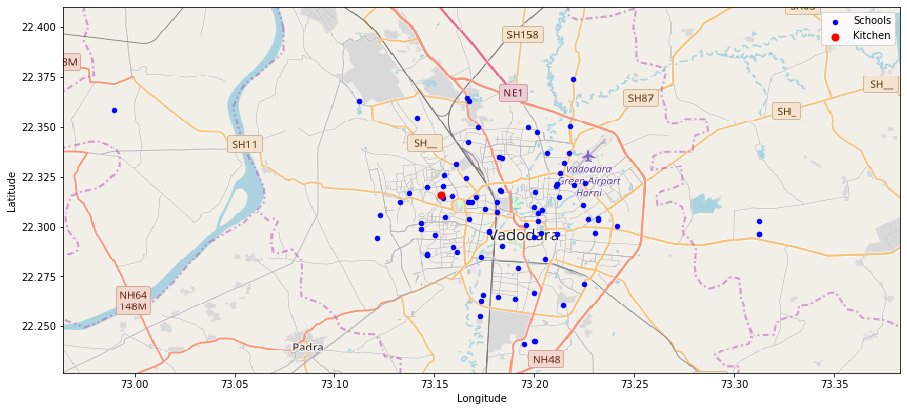

In [144]:
##### Plotting schools on map

figure, ax = plt.subplots(figsize = (15,15))
ax.scatter(school_df['long'], school_df['lat'], zorder=1, alpha= 1, c='b', s=20)
ax.scatter(school_df['long'][0], school_df['lat'][0], zorder=1, alpha= 1, c='r', marker = 'o', s=50)

BBox1 = (72.9643, 73.3832, 22.2268, 22.4098)
ruh_m1 = plt.imread('map8.png')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(BBox1[0],BBox1[1])
ax.set_ylim(BBox1[2],BBox1[3])
ax.imshow(ruh_m1, zorder=0, extent = BBox1, aspect = 'equal')
ax.legend(['Schools','Kitchen'])
plt.show()

In [133]:
##### Defining parameters for mathematical model

q = school_df['Demand'].to_numpy()                       ## demand for schools
q[0] = 0
        
n = len(school_df) - 1                                   ## number of schools
f = 3000                                                 ## fixed cost of renting truck
Q = 3600                                                 ## capacity of truck
c = 13                                                   ## cost per km of truck
d = {(i, j): school_distance[i][j] for i, j in A}        ## distance between vertices
t = {(i, j): school_distance[i][j]/50 for i, j in A}     ## time to travel between vertices
N = [i for i in range(1, n+1)]                           ## set of schools
V = [0] + N                                              ## set of vertices

A = [(i, j) for i in V for j in V if i != j]

In [135]:
##### Implementation of mathematical model on CPLEX

mdl = Model('CVRP')

x = mdl.binary_var_dict(A, name='x')
u = mdl.continuous_var_dict(N, ub=Q, name='u')
w = mdl.continuous_var(lb = 0 ,name='w')

mdl.minimize(f*w + mdl.sum(c*d[i, j]*x[i, j] for i, j in A))

mdl.add_constraints(mdl.sum(x[i, j] for j in V if j != i) == 1 for i in N)
mdl.add_constraints(mdl.sum(x[i, j] for i in V if i != j) == 1 for j in N)
mdl.add_constraints(mdl.sum(x[i, j] for j in V if j != 0) == w for i in V if i ==0)
mdl.add_indicator_constraints(mdl.indicator_constraint(x[i, j], u[i]+q[j] == u[j]) for i, j in A if i != 0 and j != 0)

mdl.add_constraints(u[i] >= q[i] for i in N)
mdl.parameters.timelimit = 500
solution = mdl.solve(log_output=True)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
CPXPARAM_TimeLimit                               500
Found incumbent of value 276201.912628 after 0.00 sec. (0.78 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 89 rows and 1 columns.
MIP Presolve modified 3828 coefficients.
Aggregator did 3828 substitutions.
Reduced MIP has 4004 rows, 11748 columns, and 26972 nonzeros.
Reduced MIP has 7832 binaries, 0 generals, 0 SOSs, and 7656 indicators.
Presolve time = 0.19 sec. (112.77 ticks)
Probing time = 0.42 sec. (63.33 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 4004 rows, 11748 columns, and 26972 nonzeros.
Reduced MIP has 7832 binaries, 0 generals, 0 SOSs, and 7656 indicators.
Presolve time = 0.08 sec. (19.06 ticks)
Probing time = 0.08 sec. (6.79 ticks)
Clique table members: 4004.
MIP emphasis: balance optimality and feasibility.
MIP search 


Performing restart 2

Repeating presolve.
Tried aggregator 1 time.
Reduced MIP has 4004 rows, 11748 columns, and 26972 nonzeros.
Reduced MIP has 7832 binaries, 0 generals, 0 SOSs, and 7656 indicators.
Presolve time = 0.05 sec. (16.60 ticks)
Tried aggregator 1 time.
Reduced MIP has 4004 rows, 11748 columns, and 26972 nonzeros.
Reduced MIP has 7832 binaries, 0 generals, 0 SOSs, and 7656 indicators.
Presolve time = 0.08 sec. (23.21 ticks)
Represolve time = 0.73 sec. (175.76 ticks)
  67990     0     1551.8602   164    23503.8436      Cuts: 38   352702   93.40%
  67990     0     1581.5350   164    23503.8436     Cuts: 118   352764   93.27%
  67990     0     1583.9256   164    23503.8436     Cuts: 173   352849   93.26%
  67990     0     1584.3400   164    23503.8436      Cuts: 88   352907   93.26%
  67990     0     1584.3400   164    23503.8436     Cuts: 192   352961   93.26%
  67990     0     1584.3400   164    23503.8436      Cuts: 32   352995   93.26%
  67990     0     1584.3400   164   

*247221+171211                        23499.1752     1587.4656            93.24%
 249280 173594     6269.6365    15    23499.1752     1587.4751  1788222   93.24%
*251096+175040                        23496.4770     1587.4807            93.24%
*252206+175748                        23480.0312     1587.4855            93.24%
*252286+176498                        23466.9292     1587.4913            93.24%
*253808+177767                        23465.4191     1587.4950            93.23%
*253990+178223                        23451.3186     1587.4950            93.23%
 254423 178898     2822.2756    34    23451.3186     1587.5003  1835266   93.23%
*255775+179320                        23402.1924     1587.5109            93.22%
*256467+180552                        23387.4066     1587.5109            93.21%
 259862 183631     1595.6238    53    23387.4066     1587.5353  1874419   93.21%

Clique cuts applied:  29
Implied bound cuts applied:  227
Mixed integer rounding cuts applied:  26
Zero-half

In [136]:
print(mdl.solution)

solution for: CVRP
objective: 23387.4
x_0_7=1
x_0_14=1
x_0_27=1
x_0_62=1
x_0_73=1
x_0_75=1
x_0_79=1
x_1_61=1
x_2_24=1
x_3_0=1
x_4_77=1
x_5_83=1
x_6_51=1
x_7_48=1
x_8_16=1
x_9_64=1
x_10_3=1
x_11_49=1
x_12_53=1
x_13_42=1
x_14_43=1
x_15_82=1
x_16_66=1
x_17_68=1
x_18_69=1
x_19_37=1
x_20_19=1
x_21_38=1
x_22_18=1
x_23_34=1
x_24_22=1
x_25_65=1
x_26_46=1
x_27_86=1
x_28_36=1
x_29_20=1
x_30_8=1
x_31_47=1
x_32_63=1
x_33_70=1
x_34_44=1
x_35_23=1
x_36_35=1
x_37_0=1
x_38_39=1
x_39_9=1
x_40_88=1
x_41_32=1
x_42_45=1
x_43_41=1
x_44_0=1
x_45_31=1
x_46_54=1
x_47_5=1
x_48_71=1
x_49_15=1
x_50_12=1
x_51_13=1
x_52_0=1
x_53_28=1
x_54_50=1
x_55_56=1
x_56_25=1
x_57_17=1
x_58_2=1
x_59_81=1
x_60_57=1
x_61_78=1
x_62_55=1
x_63_6=1
x_64_85=1
x_65_74=1
x_66_52=1
x_67_0=1
x_68_10=1
x_69_87=1
x_70_0=1
x_71_84=1
x_72_67=1
x_73_26=1
x_74_1=1
x_75_76=1
x_76_21=1
x_77_58=1
x_78_40=1
x_79_60=1
x_80_4=1
x_81_29=1
x_82_30=1
x_83_0=1
x_84_11=1
x_85_59=1
x_86_80=1
x_87_33=1
x_88_72=1
u_1=1961.000
u_2=1908.000
u_3=3600.000
u_4=1

In [137]:
active_arcs = [a for a in A if x[a].solution_value > 0.9]
print(active_arcs)

[(0, 7), (0, 14), (0, 27), (0, 62), (0, 73), (0, 75), (0, 79), (1, 61), (2, 24), (3, 0), (4, 77), (5, 83), (6, 51), (7, 48), (8, 16), (9, 64), (10, 3), (11, 49), (12, 53), (13, 42), (14, 43), (15, 82), (16, 66), (17, 68), (18, 69), (19, 37), (20, 19), (21, 38), (22, 18), (23, 34), (24, 22), (25, 65), (26, 46), (27, 86), (28, 36), (29, 20), (30, 8), (31, 47), (32, 63), (33, 70), (34, 44), (35, 23), (36, 35), (37, 0), (38, 39), (39, 9), (40, 88), (41, 32), (42, 45), (43, 41), (44, 0), (45, 31), (46, 54), (47, 5), (48, 71), (49, 15), (50, 12), (51, 13), (52, 0), (53, 28), (54, 50), (55, 56), (56, 25), (57, 17), (58, 2), (59, 81), (60, 57), (61, 78), (62, 55), (63, 6), (64, 85), (65, 74), (66, 52), (67, 0), (68, 10), (69, 87), (70, 0), (71, 84), (72, 67), (73, 26), (74, 1), (75, 76), (76, 21), (77, 58), (78, 40), (79, 60), (80, 4), (81, 29), (82, 30), (83, 0), (84, 11), (85, 59), (86, 80), (87, 33), (88, 72)]


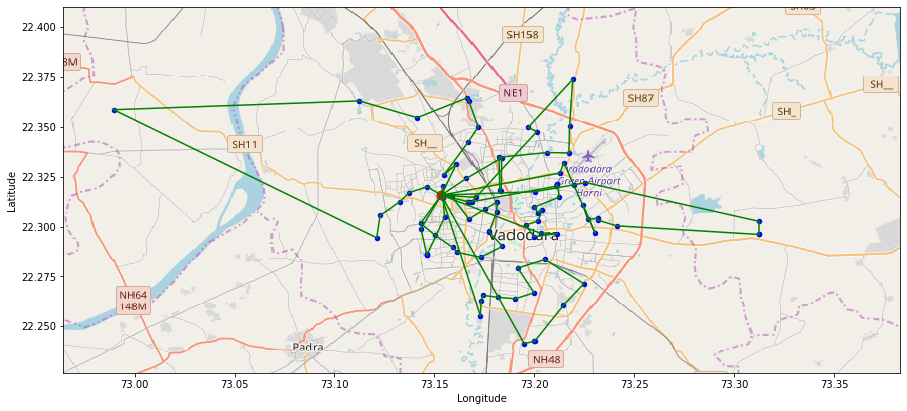

In [150]:
##### Displaying vehicle routes on map

figure, ax = plt.subplots(figsize = (15,15))

ax.scatter(school_df['long'], school_df['lat'], zorder=1, alpha= 1, c='b', s=20)
ax.scatter(school_df['long'][0], school_df['lat'][0], zorder=1, alpha= 1, c='r', marker = 'o', s=80)
BBox1 = (72.9643, 73.3832, 22.2268, 22.4098)
ruh_m1 = plt.imread('map8.png')

for i, j in active_arcs:
    ax.plot([school_df['long'][i], school_df['long'][j]], [school_df['lat'][i], school_df['lat'][j]], c='g', alpha=1)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(BBox1[0],BBox1[1])
ax.set_ylim(BBox1[2],BBox1[3])
ax.imshow(ruh_m1, zorder=0, extent = BBox1, aspect = 'equal')
plt.show()

In [139]:
##### Importing crossdocking data

crossdocking_df = pd.read_csv("C:/Users/rifle/Documents/My Docs/Concordia/2 - Winter 2020/INDU 6121 - Applied Optimization/Project/Data/Crossdocking _co-ordinates.csv")

crossdocking_df = crossdocking_df.drop(columns="Unnamed: 0")
crossdocking_df['lat'] = crossdocking_df.apply(lambda site: site['Coordinates'].split(",")[0], axis = 1).astype(float)
crossdocking_df['long'] = crossdocking_df.apply(lambda site: site['Coordinates'].split(",")[1], axis = 1).astype(float)

display(crossdocking_df)

,Coordinates,lat,long
0,"22.315718, 73.153501",22.315718,73.153501
1,"22.301166, 73.201483",22.301166,73.201483
2,"22.263564, 73.190167",22.263564,73.190167
3,"22.310159, 73.239059",22.310159,73.239059
4,"22.268982, 73.157204",22.268982,73.157204
5,"22.348579, 73.191896",22.348579,73.191896
6,"22.242878, 73.206868",22.242878,73.206868
7,"22.298295, 73.187849",22.298295,73.187849
8,"22.335076, 73.210569",22.335076,73.210569


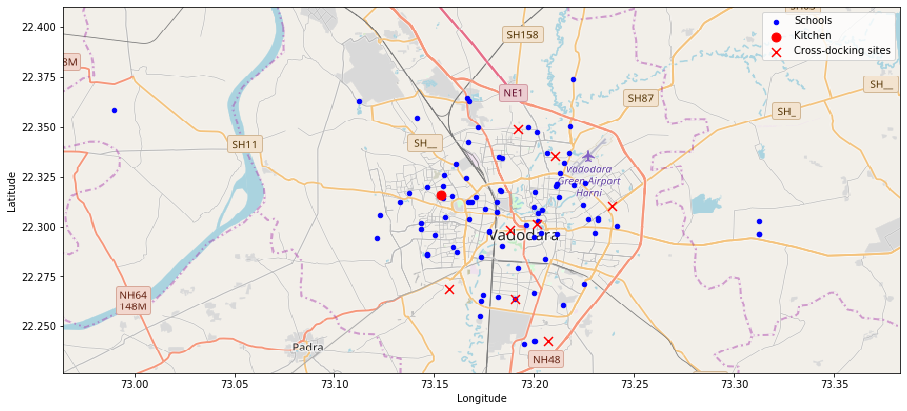

In [151]:
##### Plotting cross-docking sites on map

figure, ax = plt.subplots(figsize = (15,15))
ax.scatter(school_df['long'], school_df['lat'], zorder=1, alpha= 1, c='b', s=20)
ax.scatter(school_df['long'][0], school_df['lat'][0], zorder=1, alpha= 1, c='r', marker = 'o', s=80)
ax.scatter(crossdocking_df['long'][1:], crossdocking_df['lat'][1:], zorder=1, alpha= 1, c='r',marker = 'x', s=80)

BBox1 = (72.9643, 73.3832, 22.2268, 22.4098)
ruh_m1 = plt.imread('map8.png')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(BBox1[0],BBox1[1])
ax.set_ylim(BBox1[2],BBox1[3])
ax.imshow(ruh_m1, zorder=0, extent = BBox1, aspect = 'equal')
ax.legend(['Schools','Kitchen','Cross-docking sites'])
plt.show()

In [141]:
##### Calculating distance between cross-docking sites and schools

CD_distance = np.zeros([len(crossdocking_df),len(school_df)-1])
for i in range(len(crossdocking_df)):
    coords_1 = crossdocking_df.Coordinates[i]
    for j in range(1,len(school_df)):
        coords_2 = school_df.Coordinates[j]
        CD_distance[i][j-1] = geo.distance(coords_1, coords_2).km
        
print(CD_distance)

[[ 3.2030747   5.08643235  2.1387031   4.65393397  1.68717819  5.56546383
   6.96622804  8.76897029  8.15676196  3.32424414  6.89632804  5.95088533
   6.72240057  1.89509649  5.64222619  9.4268607   3.38413313  6.0062509
   6.84518954  7.45772228  8.18977625  6.08209679  6.03849959  4.81973685
   3.27358358  3.73486136  5.54597705  7.6386356  16.43933592  8.83599675
   3.35532079  4.22832011  1.44379486  1.61904008  5.84918837  9.32879326
   4.82031055  7.31193805  7.65850398  2.91480523  3.27292527 17.54738351
   1.13405982  1.77284086  4.0860556   3.09705122  2.16903296  6.23410104
   7.22208123  3.63794474  4.46943221  9.26735167  6.97873706  3.0278719
   2.2530072   2.95032467  1.23513808  5.25080625 16.52231828  0.19219752
   3.18694843  1.89705456  5.40350629  8.17081514  3.99805099  9.41749312
   0.52634385  3.39623889  5.99213515  1.53754904  5.94932194  1.93537265
   1.58253491  4.24078369  6.23642744  6.56489402  5.19029621  3.00448518
   0.48887075  5.29984903 16.52189201  6